In [ ]:
import locale
from IPython.display import clear_output
locale.getpreferredencoding = lambda: "UTF-8"

!sudo apt-get update
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
clear_output()

In [ ]:
from IPython.display import clear_output
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install simbench
!pip install pandapower==2.11.1
clear_output()

# Let's do some necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os

import pandapower as pp
import pandapower.plotting as plot
import simbench as sb
import torch

In [ ]:
torch.manual_seed(0)
sb_code1= "1-MV-rural--0-sw"
net = sb.get_simbench_net(sb_code1)

profiles = net.profiles["load"]

active_keys = list(filter(lambda x: x[-5:]=='pload', list(profiles.keys())))
reactive_keys = list(filter(lambda x: x[-5:]=='qload', list(profiles.keys())))

active_df = profiles[active_keys]
active_df.columns = list(map(lambda x: x[:-6], active_keys))
reactive_df = profiles[reactive_keys]
reactive_df.columns = list(map(lambda x: x[:-6], reactive_keys))

active_loads_profiles_np = active_df.to_numpy()
reactive_loads_profiles_np = reactive_df.to_numpy()

#complex_power_profiles = np.vectorize(complex)(active_loads_profiles_np, reactive_loads_profiles_np) * 1e3
#complex_power_profiles = active_loads_profiles_np*1e3
complex_power_profiles = reactive_loads_profiles_np*1e3
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


/usr/local/lib/python3.10/dist-packages/simbench/converter/auxiliary.py:119: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat(dfs, axis=0, **kwargs)


In [ ]:
complex_power_profiles[:5, 0]

array([282.542, 389.736, 402.408, 329.803, 385.284])

In [ ]:
reactive_df.head()*1000

,G0-A,G0-M,G3-A,G3-M,L0-A,L2-M,lv_rural1,lv_rural2,lv_rural3,lv_semiurb4
0,282.542,256.264,241.342,251.059,269.972,359.739,227.082,55.725,42.631,49.155
1,389.736,473.602,160.782,309.901,269.972,452.681,425.858,114.666,110.576,164.687
2,402.408,376.287,232.880,309.901,282.529,461.428,458.658,104.153,96.685,151.748
3,329.803,434.676,135.395,305.978,301.364,472.363,459.331,43.749,27.595,87.226
4,385.284,437.920,177.707,294.210,276.250,459.242,442.274,57.962,41.130,94.185


# Dataset Class Creation

In [ ]:
class ComplexLoadsDataset(torch.utils.data.Dataset):
  def __init__(self, X, seq_length, statistics, device):
    mu_re, mu_im, std_re, std_im = statistics
    X_re = self.normalize_data(np.real(X), mu_re, std_re)
    X_im = self.normalize_data(np.imag(X), mu_im, std_im)
    self.X_norm = self.complexify(X_re, X_im)
    data = X, self.X_norm
    self.input, self.target = self.sliding_windows(data, seq_length, device)

  def complexify(self, X_re, X_im):
    return np.vectorize(complex)(X_re, X_im)

  def normalize_data(self, X, mu, sigma):
    if sigma==0.0:
      return (X - mu)/(sigma + 1e-7)
    else:
      return (X - mu)/sigma


  def __getitem__(self, idx):
    return self.input[idx, ...], self.target[idx, ...]

  def __len__(self):
    return self.input.shape[0]

  def get_statistics(self):
    return self.mu_re, self.mu_im, self.std_re, self.std_im



  def sliding_windows(self, data: tuple, seq_length, device):
    data_true, data_norm = data

    x = list()
    y = list()

    for i in range(len(data_norm)-seq_length-1):
      _x = data_norm[i:(i+seq_length)]
      _y = data_norm[i+seq_length]
      x.append(_x)
      y.append(_y)

    x = torch.from_numpy(np.array(x)).to(device).type(torch.complex64)
    y = torch.from_numpy(np.array(y)).to(device).type(torch.complex64)
    x = torch.reshape(x, (*x.size(), 1))
    y = torch.reshape(y, (*y.size(), 1))
    return x, y

  def get_tensor_data(self):
    return self.input, self.target

In [ ]:
def draw_plots(i, y, target, future, path, statistics, load):
  mu_re, mu_im, std_re, std_im = statistics
  def draw(yi, target, ax, colour="k", show_leg=True):
    if show_leg:
      ax.plot(np.append(np.array([None]), target), color="k" , linewidth=0.75,
              label=r'Target sequence $\bm y$')
      ax.plot(np.arange(n), yi[:n], "--", linewidth=0.5, color="b",
              label=r'$t + 1$ prediction $\hat{\bm y}$')

      ax.legend(loc='upper right')
    else:
      ax.plot(np.append(np.array([None]), target), color="k" , linewidth=0.75)
      ax.plot(np.arange(n), yi[:n], "--", linewidth=0.5, color="b")


    if future > 0:
      ax.plot(np.arange(n, n + future), yi[-future:], "--", linewidth=0.75, color="r")
              #label=r'$t + {{{}}}$ prediction'.format(future))


  def draw_metrics(yi, target, ax, complex_type, statistics):

    if complex_type == "Re":
      color = ["r", "g"]
      #label_mad = r'$L^1$ deviation (MAD)'
      #label_ts = r'$\operatorname{Re}$(TS)'
    elif complex_type == "Im":
      color = ["r", "m"]
      #label_mad = r'$L^1$ deviation (MAD)'
      #label_ts = r'$\operatorname{Im}$(TS)'
    if future == 0:
      target = torch.squeeze(target)
      error = target - yi
      tracking_signal = list()
      mad = list()
      l1 = torch.nn.L1Loss(reduction="mean")
      yi = torch.tensor(yi)
      yi = yi.view(-1)
      for index, _ in enumerate(error):
        cum_sum = torch.sum(error[:index])
        running_mad = l1(yi[:index], target[:index])
        mad.append(running_mad.numpy())
        tracking_signal.append((cum_sum/running_mad).numpy())

      ax[0].plot(np.arange(n + future), mad, ":", linewidth=0.5, color=color[0])
      #label=label_mad)
      ax[1].plot(np.arange(n + future), tracking_signal, linewidth=0.5, color=color[1])
      #label=label_ts)
      ax[0].legend(loc='upper right')#, prop={'size': 6})
      ax[1].legend(loc='upper right')#, prop={'size': 6})
  n = target.shape[0] - future # 999
  for idx in range(min(len(y), 1)):
    fig1, axs = plt.subplots(nrows=2, ncols=1,figsize=(15, 7.5), #width, height
                            sharex=True,constrained_layout=True)
    #if isinstance(i, int):
    #  fig1.suptitle('Señal de validación: época {}'.format(i + 1))
    #else:
    #  fig1.suptitle(load + ' test forecasts vs target series')
    axs[0].set_ylabel("kW")
    axs[0].set_title(r"$\hat{\bm y}_{\mathbb{R}, \rm test}$, $\bm y_{\mathbb{R}, \rm test}$")
    draw(np.real(y)*std_re + mu_re, np.real(target)*std_re + mu_re, axs[0])

    plt.savefig(path + load + " test.png", dpi=50)

    plt.close()

# LSTM Cell Architecture (CHLR)

# Network Architecture

In [ ]:
class RealLSTMNetwork(torch.nn.Module):

  def __init__(self,
               input_size,
               hidden_size,
               num_classes,
               seq_length,
               device,
               bias=True,
               dropout=0.0,
               batch_first=True,
               bidirectional=False):
    super(RealLSTMNetwork, self).__init__()
    self.hidden_layers = hidden_size
    self.hidden_layers_2 = int(hidden_size/2)
    self.hidden_layers_4 = int(hidden_size/4)
    self.hidden_layers_8 = int(hidden_size/8)
    self.hidden_layers_16 = int(hidden_size/16)


    self.seq_length = seq_length
    self.relu = torch.nn.ReLU()

    self.relu1 = torch.nn.ReLU()
    self.relu2 = torch.nn.ReLU()
    self.relu3 = torch.nn.ReLU()
    self.relu4 = torch.nn.ReLU()
    num_layers = 2
    self.layer1 = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, dtype=torch.float32, batch_first=batch_first)
    self.linear1 = torch.nn.Linear(hidden_size, int(hidden_size/2), dtype=torch.float32)
    dropout = 0.0
    num_layers = 1
    self.layer2 = torch.nn.LSTM(int(hidden_size/2), int(hidden_size/2),  num_layers, dropout=dropout, batch_first=batch_first)
    self.linear2 = torch.nn.Linear(int(hidden_size/2), int(hidden_size/4), dtype=torch.float32)
    self.layer3 = torch.nn.LSTM(int(hidden_size/4), int(hidden_size/4),  num_layers, dropout=dropout, batch_first=batch_first)
    self.linear3 = torch.nn.Linear(int(hidden_size/4), int(hidden_size/8), dtype=torch.float32)
    self.layer4 = torch.nn.LSTM(int(hidden_size/8), int(hidden_size/8),  num_layers, dropout=dropout, batch_first=batch_first)
    self.linear4 = torch.nn.Linear(int(hidden_size/8), int(hidden_size/16), dtype=torch.float32)
    self.layer5 = torch.nn.LSTM(int(hidden_size/16), int(hidden_size/16), num_layers, dropout=dropout, batch_first=batch_first)
    self.linear5 = torch.nn.Linear(int(hidden_size/16), num_classes, dtype=torch.float32)

    self.flag = True
    self.device = device

  def forward(self, X):
    outputs, n_samples = list(), X.size(0)

    num_layers = 2

    h_t1 = torch.zeros(num_layers, n_samples, self.hidden_layers, dtype=torch.float32).to(self.device).contiguous()
    c_t1 = torch.zeros(num_layers, n_samples, self.hidden_layers, dtype=torch.float32).to(self.device).contiguous()

    num_layers = 1

    h_t2 = torch.zeros(num_layers, n_samples, self.hidden_layers_2, dtype=torch.float32).to(self.device).contiguous()
    c_t2 = torch.zeros(num_layers, n_samples, self.hidden_layers_2, dtype=torch.float32).to(self.device).contiguous()

    h_t3 = torch.zeros(num_layers, n_samples, self.hidden_layers_4, dtype=torch.float32).to(self.device).contiguous()
    c_t3 = torch.zeros(num_layers, n_samples, self.hidden_layers_4, dtype=torch.float32).to(self.device).contiguous()

    h_t4 = torch.zeros(num_layers, n_samples, self.hidden_layers_8, dtype=torch.float32).to(self.device).contiguous()
    c_t4 = torch.zeros(num_layers, n_samples, self.hidden_layers_8, dtype=torch.float32).to(self.device).contiguous()

    h_t5 = torch.zeros(num_layers, n_samples, self.hidden_layers_16, dtype=torch.float32).to(self.device).contiguous()
    c_t5 = torch.zeros(num_layers, n_samples, self.hidden_layers_16, dtype=torch.float32).to(self.device).contiguous()



    output, (h_t1, c_t1) = self.layer1(X, (h_t1, c_t1))
    output = self.linear1(output)
    output = self.relu1(output)

    output, (h_t2, c_t2) = self.layer2(output, (h_t2, c_t2))
    output = self.linear2(output)
    output = self.relu2(output)

    output, (h_t3, c_t3) = self.layer3(output, (h_t3, c_t3))
    output = self.linear3(output)
    output = self.relu3(output)

    output, (h_t4, c_t4) = self.layer4(output, (h_t4, c_t4))
    output = self.linear4(output)
    output = self.relu4(output)

    output, (h_t5, c_t5) = self.layer5(output, (h_t5, c_t5))
    output = self.linear5(output)


    output = torch.squeeze(output)

    outputs.append(output[:, -1:])

    outputs = torch.cat(outputs, dim=1)

    return outputs

# Batched Training Loop

In [ ]:
def batched_training_loop(
                  n_epochs,
                  model,
                  optimizer,
                  loss_fn,
                  train_dataloader,
                  val_set,
                  test_set,
                  statistics,
                  path,
                  val=True):
  train_loss = list()
  val_loss = list()
  future = 0
  val_target = None
  if val:
    val_input, val_target = val_set.get_tensor_data()
    val_input = torch.real(val_input)
    val_target = torch.real(val_target)
  val_signal_epochs = dict()
  val_signal_epochs["target"] = val_target
  test_signal = dict()

  def closure():
    optimizer.zero_grad()
    out = model(train_input)
    loss = loss_fn(out, train_target)
    loss.backward()
    return loss

  for i in range(n_epochs):
    batch_train_loss = list()
    batch_val_loss = list()
    model.train()
    for train_input, train_target in train_dataloader:
      train_input = torch.real(train_input)
      train_target = torch.real(train_target)
      loss = closure()
      batch_train_loss.append(np.real(loss.cpu().detach().numpy()))
      optimizer.step(closure)
    train_epoch_loss = np.mean(batch_train_loss)
    train_loss.append(train_epoch_loss)
    if val:
      with torch.no_grad():
        model.eval()
        pred = model(val_input)
        loss_ = loss_fn(pred, val_target)
        # use all pred samples, but only go to 999
      # batch_val_loss.append(torch.real(loss_).cpu().detach().numpy())
        y = pred.cpu().detach().numpy()

      val_epoch_loss = torch.real(loss_).cpu().detach().numpy()
      val_loss.append(val_epoch_loss)

    # draw figures

    if i%1 == 0:
      if val:
        draw_path = path["val"]
        draw_plots(i, y, val_target.cpu(), future, draw_path, statistics, load)
      # print the loss

        val_signal_epochs[i] = y

      # test

        print("Epoch: {}\n - Train Loss: {}\n - Val Loss: {}".format(i, train_epoch_loss, val_epoch_loss))
        torch.save(model.state_dict(), "models/{}.pth".format(i))
      else:
        print("Epoch: {}\n - Train Loss: {}\n".format(i, train_epoch_loss))

  if val:
    best_epoch_idx = val_loss.index(min(val_loss))
    print("Best epoch: ", best_epoch_idx)
    state_dict = torch.load("models/{}.pth".format(best_epoch_idx))
    model.load_state_dict(state_dict)
  with torch.no_grad():
    model.eval()
    if val:
      batch_val_loss = list()
      pred = model(val_input)
      loss_ = loss_fn(pred, val_target)
      # use all pred samples, but only go to 999
      batch_val_loss.append(torch.real(loss_).cpu().detach().numpy())
      val_epoch_loss = np.mean(batch_val_loss)
      print("Verify epoch loss", val_epoch_loss)


    test_input, test_target = test_set.get_tensor_data()
    test_input = torch.real(test_input)
    test_target = torch.real(test_target)
    pred = model(test_input)
    test_loss = loss_fn(pred, test_target)
    # use all pred samples, but only go to 999
    y = pred.cpu().detach().numpy()
    #draw_path = path["test"]
    test_signal["target"] = test_target.cpu().detach().numpy()
    test_signal["pred"] = y
    i = "test"
    print("Test Loss: {}".format(torch.real(test_loss).cpu().detach().numpy()))

  return train_loss, val_loss, val_signal_epochs, test_signal

In [ ]:
loads = list(reactive_df.keys())
loads

['G0-A',
 'G0-M',
 'G3-A',
 'G3-M',
 'L0-A',
 'L2-M',
 'lv_rural1',
 'lv_rural2',
 'lv_rural3',
 'lv_semiurb4']

In [ ]:
def dataset_formation(load_idx, semester, complex_power_profiles, seq_length=144, batch_size=7, val=False):
  if val:

    train_size = 14054 # 80%
    val_size = 1758# 10%
    test_size = 1756 # 10 %

  else:
    train_size = 14054 + 1757 # 80%
    val_size = 0
    test_size = 1757 # 10 %

  if semester == 1:

    mu_re = np.real(complex_power_profiles[:train_size, load_idx]).mean()
    mu_im = np.imag(complex_power_profiles[:train_size, load_idx]).mean()
    std_re = np.real(complex_power_profiles[:train_size, load_idx]).std()
    std_im = np.imag(complex_power_profiles[:train_size, load_idx]).std()
    statistics = (mu_re, mu_im, std_re, std_im)
    print(statistics)

    train_set = ComplexLoadsDataset(complex_power_profiles[:train_size, load_idx], seq_length, statistics, device)
    if val:
      val_set = ComplexLoadsDataset(complex_power_profiles[train_size:(train_size + val_size), load_idx], seq_length, statistics, device)
    else:
      val_set = None
    test_set = ComplexLoadsDataset(complex_power_profiles[train_size + val_size:(train_size + val_size + test_size), load_idx], seq_length, statistics, device)

    load = loads[load_idx] + " I"

  else:

    offset = train_size + val_size + test_size
    mu_re = np.real(complex_power_profiles[offset: offset + train_size, load_idx]).mean()
    mu_im = np.imag(complex_power_profiles[offset: offset + train_size, load_idx]).mean()
    std_re = np.real(complex_power_profiles[offset: offset + train_size, load_idx]).std()
    std_im = np.imag(complex_power_profiles[offset: offset + train_size, load_idx]).std()
    statistics = (mu_re, mu_im, std_re, std_im)
    print(statistics)

    train_set = ComplexLoadsDataset(complex_power_profiles[offset: offset + train_size, load_idx], seq_length, statistics, device)
    if val:
      val_set = ComplexLoadsDataset(complex_power_profiles[offset + train_size: offset + (train_size + val_size), load_idx], seq_length, statistics, device)
    else:
      val_set = None
    test_set = ComplexLoadsDataset(complex_power_profiles[offset + train_size + val_size: offset + (train_size + val_size + test_size), load_idx], seq_length, statistics, device)

    load = loads[load_idx] + " II"

  train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
  if val:
    val_dataloader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=0)
  else:
    val_dataloader = None
    return train_dataloader, val_set, test_set, statistics

In [ ]:
import matplotlib as mpl
pgf_with_rc_fonts = {
    "font.family": "serif",
}
mpl.rcParams.update(pgf_with_rc_fonts)

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsfonts}\usepackage{amsmath}\usepackage{bm}\renewcommand{\rmdefault}{ptm}')
font = {'size'   : 14}
rc('font', **font)

In [ ]:
def metric(signal, path, load_name, df, load_type):
  metrics = dict()
  sem = ["I", "II"]
  errors = signal["target"] - signal["pred"]
  metrics["MAD"] = np.mean(np.abs(errors))
  metrics["MAPE"] = np.mean([error/signal["target"][idx] for idx, error in enumerate(np.abs(errors)) if signal["target"][idx] > 0.1])
  metrics["BIAS"] = np.mean(errors)
  metrics["MSE"] = np.mean(errors**2)
  metrics["RMSE"] = np.sqrt(np.mean(errors**2))
  print("RMSE:", round(metrics["RMSE"], 2))
  print("BIAS:", round(metrics["BIAS"], 2))
  print("MAPE:", round(100*metrics["MAPE"], 2))
  df1 = pd.DataFrame(metrics, index=[load_name])
  df1.to_csv(path)
  df.loc[load_name + " " + sem[semester - 1] + " " + load_type] = metrics
  return errors, metrics, df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for load_idx, load_name in enumerate(loads[1:3]):
  print(load_idx, load_name)

0 G0-M
1 G3-A


In [ ]:
torch.manual_seed(0)
n_epochs = 10
input_size = 1
hidden_size = 192
output_size = 1
dropout = 0.25

batch_size = 7
seq_length = 144
semester = 1
val=False

p = False
q = True
s = p and q

print(s)


metric_df = pd.DataFrame(columns=["MAD", "MAPE", "BIAS", "MSE", "RMSE"])

for load_idx, load_name in enumerate(loads):
  for semester in range(1,3):
    train_dataloader, val_set, test_set, statistics = dataset_formation(load_idx, semester, complex_power_profiles, seq_length=seq_length, batch_size=batch_size)

    model = RealLSTMNetwork(input_size, hidden_size, output_size, seq_length, device, dropout=dropout)
    model.to(device)
    loss_fn = torch.nn.MSELoss()

    path = {"val": "/content/drive/val_runs/"+load_name+"/", "test": "/content/drive/MyDrive/results/test/"+ load_name + "/",}
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(load_idx, load_name)
    train_loss, val_loss, val_signal_epochs, test_signal = batched_training_loop(n_epochs, model, optimizer, loss_fn,
                      train_dataloader, val_set, test_set, statistics, path, val=val)

    train_params = {"train loss": train_loss, "val loss": val_loss}
    if val:
      df = pd.DataFrame(train_params)
      df.to_csv(load_name + " learning curves.csv")

    if p and not s:
      path["test"] += "active_only/"
      p_signal = {"target": np.real(test_signal["target"])*statistics[2] + statistics[0],
                  "pred": np.real(test_signal["pred"])*statistics[2] + statistics[0]}

      p_hat = pd.Series(p_signal["pred"][:, 0])
      p_hat = p_hat.rename("p_hat")
      p_target = pd.Series(p_signal["target"][:, 0])
      p_target = p_target.rename("p_target")
      p_df = pd.concat([p_hat, p_target], axis=1)
      p_df.to_csv(path["test"]+ "semester_" + str(semester) + "_active_results.csv")
      print("P")
      p_error, p_metrics, metric_df  = metric(p_signal, path["test"] + "semester_" + str(semester)+"_active_metrics.csv", load_name, metric_df, "p")

    elif q and not s:
      path["test"] += "reactive_only/"
      q_signal = {"target": np.real(test_signal["target"])*statistics[2] + statistics[0],
                  "pred": np.real(test_signal["pred"])*statistics[2] + statistics[0]}

      q_hat = pd.Series(q_signal["pred"][:, 0])
      q_target = pd.Series(q_signal["target"][:, 0])
      q_hat = q_hat.rename("q_hat")
      q_target = q_target.rename("q_target")
      q_df = pd.concat([q_hat, q_target], axis=1)
      q_df.to_csv(path["test"] + "semester_" + str(semester) + "_reactive_results.csv")
      print("Q")
      q_error, q_metrics, metric_df = metric(q_signal, path["test"] + "semester_" + str(semester)+"_rective_metrics.csv", load_name, metric_df, "q")


    elif s:
      path["test"] += "complex/"
      p_signal = {"target": np.real(test_signal["target"])*statistics[2] + statistics[0],
                  "pred": np.real(test_signal["pred"])*statistics[2] + statistics[0]}

      p_hat = pd.Series(p_signal["pred"][:, 0])
      p_hat = p_hat.rename("p_hat")
      p_target = pd.Series(p_signal["target"][:, 0])
      p_target = p_target.rename("p_target")
      p_df = pd.concat([p_hat, p_target], axis=1)

      print("P")
      p_error, p_metrics, metric_df  = metric(p_signal, path["test"] + "semester_" +str(semester) +"_complex_active_metrics.csv", load_name, metric_df, "p")


      q_signal = {"target": np.imag(test_signal["target"])*statistics[3] + statistics[1],
                  "pred": np.imag(test_signal["pred"])*statistics[3] + statistics[1]}

      q_hat = pd.Series(q_signal["pred"][:, 0])
      q_target = pd.Series(q_signal["target"][:, 0])
      q_hat = q_hat.rename("q_hat")
      q_target = q_target.rename("q_target")
      q_df = pd.concat([p_hat, p_target], axis=1)
      s_df = pd.concat([p_df, q_df], axis=1)
      s_df.to_csv(path["test"]+ "semester_" + str(semester) + "_complex_results.csv")
      print("Q")
      q_error, q_metrics, metric_df = metric(q_signal, path["test"] + "semester_" + str(semester)+"_complex_rective_metrics.csv", load_name, metric_df, "q")



if p and not s:
  metric_df.to_csv("/content/drive/MyDrive/results/test/" + "final_active_only_metrics.csv")

elif q and not s:
  metric_df.to_csv("/content/drive/MyDrive/results/test/" + "final_reactive_only_metrics.csv")

elif s:
  metric_df.to_csv("/content/drive/MyDrive/results/test/" + "final_complex_metrics.csv")
print(metric_df)

False
(368.85889678072226, 0.0, 79.51030991802325, 0.0)
0 G0-A
Epoch: 0
 - Train Loss: 0.9541565179824829

Epoch: 1
 - Train Loss: 0.9494596123695374

Epoch: 2
 - Train Loss: 0.9492441415786743

Epoch: 3
 - Train Loss: 0.9495067596435547

Epoch: 4
 - Train Loss: 0.9532157778739929

Epoch: 5
 - Train Loss: 0.9595064520835876

Epoch: 6
 - Train Loss: 0.9613468050956726

Epoch: 7
 - Train Loss: 1.0016542673110962

Epoch: 8
 - Train Loss: 1.0073955059051514

Epoch: 9
 - Train Loss: 1.0075972080230713

Test Loss: 3.8295350074768066
Q
RMSE: 155.6
BIAS: 126.05
MAPE: 24.86
(448.24134798557964, 0.0, 109.26241416861481, 0.0)
0 G0-A
Epoch: 0
 - Train Loss: 0.8233833312988281

Epoch: 1
 - Train Loss: 1.0063621997833252

Epoch: 2
 - Train Loss: 1.006320595741272

Epoch: 3
 - Train Loss: 1.005942940711975

Epoch: 4
 - Train Loss: 1.0054686069488525

Epoch: 5
 - Train Loss: 1.005859375

Epoch: 6
 - Train Loss: 1.0056090354919434

Epoch: 7
 - Train Loss: 1.0055763721466064

Epoch: 8
 - Train Loss: 1.0

In [ ]:
torch.manual_seed(0)
n_epochs = 10
input_size = 1
hidden_size = 192
output_size = 1
dropout = 0.25

batch_size = 7
seq_length = 144
semester = 1
val=False


model = RealLSTMNetwork(input_size, hidden_size, output_size, seq_length, device, dropout=dropout)

In [ ]:
def count_parameters(model):
   return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

570241


In [ ]:
for adress in path.values():
  for file_name in os.listdir(adress):
      # construct full file path
      file = adress + "/" + file_name
      if os.path.isfile(file):
          os.remove(file)

  os.rmdir(adress)

# Clear Memory

In [ ]:
from torch import cuda

def get_less_used_gpu(gpus=None, debug=False):
    """Inspect cached/reserved and allocated memory on specified gpus and return the id of the less used device"""
    if gpus is None:
        warn = 'Falling back to default: all gpus'
        gpus = range(cuda.device_count())
    elif isinstance(gpus, str):
        gpus = [int(el) for el in gpus.split(',')]

    # check gpus arg VS available gpus
    sys_gpus = list(range(cuda.device_count()))
    if len(gpus) > len(sys_gpus):
        gpus = sys_gpus
        warn = f'WARNING: Specified {len(gpus)} gpus, but only {cuda.device_count()} available. Falling back to default: all gpus.\nIDs:\t{list(gpus)}'
    elif set(gpus).difference(sys_gpus):
        # take correctly specified and add as much bad specifications as unused system gpus
        available_gpus = set(gpus).intersection(sys_gpus)
        unavailable_gpus = set(gpus).difference(sys_gpus)
        unused_gpus = set(sys_gpus).difference(gpus)
        gpus = list(available_gpus) + list(unused_gpus)[:len(unavailable_gpus)]
        warn = f'GPU ids {unavailable_gpus} not available. Falling back to {len(gpus)} device(s).\nIDs:\t{list(gpus)}'

    cur_allocated_mem = {}
    cur_cached_mem = {}
    max_allocated_mem = {}
    max_cached_mem = {}
    for i in gpus:
        cur_allocated_mem[i] = cuda.memory_allocated(i)
        cur_cached_mem[i] = cuda.memory_reserved(i)
        max_allocated_mem[i] = cuda.max_memory_allocated(i)
        max_cached_mem[i] = cuda.max_memory_reserved(i)
    min_allocated = min(cur_allocated_mem, key=cur_allocated_mem.get)
    if debug:
        print(warn)
        print('Current allocated memory:', {f'cuda:{k}': v for k, v in cur_allocated_mem.items()})
        print('Current reserved memory:', {f'cuda:{k}': v for k, v in cur_cached_mem.items()})
        print('Maximum allocated memory:', {f'cuda:{k}': v for k, v in max_allocated_mem.items()})
        print('Maximum reserved memory:', {f'cuda:{k}': v for k, v in max_cached_mem.items()})
        print('Suggested GPU:', min_allocated)
    return min_allocated


def free_memory(to_delete: list, debug=False):
    import gc
    import inspect
    calling_namespace = inspect.currentframe().f_back
    if debug:
        print('Before:')
        get_less_used_gpu(debug=True)

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        cuda.empty_cache()
    if debug:
        print('After:')
        get_less_used_gpu(debug=True)

In [ ]:
free_memory([model])

In [ ]:
free_memory([test_set])

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
rc('font', **{'family': 'OT', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [ ]:
#font = {'size'   : 22}
#rc('font', **font)
fig1, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,15), #width, height
                            sharex=True,constrained_layout=True)

axs[0].set_ylabel("kW")
axs[0].set_title(r"Potencia activa: $y$")
axs[1].set_ylabel("kVAr")
axs[1].set_title("Potencia reactiva: $y$")
axs[1].set_xlabel(r"Timesteps $t$")

max_timestep = 1758
target = True
for key, value in val_signal_epochs.items():
  if is_cuda:
    if target:
      value = value.cpu().detach().numpy()
      target = False
    #value = value.cpu()
  else:
    value = value.cpu().detach().numpy()
  if isinstance(key, int):
    if key%3 == 0:
      axs[0].plot(np.real(value[:max_timestep])*statistics[2] + statistics[0], linestyle='dashed', linewidth=0.75, label=r'Epoch ${{{}}}$'.format(key + 1))
      axs[1].plot(np.imag(value[:max_timestep])*statistics[3] + statistics[1], linestyle='dashed', linewidth=0.75, label=r'Epoch ${{{}}}$'.format(key + 1))
  else:
    #value = value.detach().cpu().numpy()
    axs[0].plot(np.append(np.array([None]*1), np.real(value[:max_timestep])*statistics[2] + statistics[0]), color="k" , linewidth=0.75, label=r'Target sequence')
    axs[1].plot(np.append(np.array([None]*1), np.imag(value[:max_timestep])*statistics[3] + statistics[1]), color="k" , linewidth=0.75, label=r'Target sequence')

axs[0].legend(loc='upper right')

plt.savefig("validaciones_epochs.pdf", dpi=200)


In [ ]:
test_signal

{'target': array([[-0.4213273 +0.941745j ],
        [-0.17329384+0.6559157j],
        [-0.2483541 +0.4463122j],
        ...,
        [ 2.5290117 +6.401082j ],
        [ 2.4767966 +6.3153324j],
        [ 2.2222307 +5.9342294j]], dtype=complex64),
 'pred': array([[-0.19611295+1.3360952j],
        [-0.4029382 +0.5163268j],
        [-0.1909205 +0.710708j ],
        ...,
        [ 1.658245  +3.0815957j],
        [ 1.8740107 +3.162624j ],
        [ 1.740764  +3.1430302j]], dtype=complex64)}

In [ ]:
statistics

(106.64831102888857, 41.15590758588302, 46.34475803870857, 15.871903144952192)

In [ ]:
fig1, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,15), #width, height
                            sharex=True,constrained_layout=True)

axs[0].set_ylabel("kW")
axs[0].set_title(r"Potencia activa: ")
axs[1].set_ylabel("kVAr")
axs[1].set_title(r"Potencia reactiva")
axs[1].set_xlabel(r"Timesteps $t$")

max_timestep = 1756

axs[0].plot(np.append(np.array([None]*1), np.real(test_signal["target"][:max_timestep]*statistics[2] + statistics[0])), color="k" , linewidth=0.75, label=r'Target sequence')
axs[1].plot(np.append(np.array([None]*1), np.imag(test_signal["target"][:max_timestep]*statistics[3] + statistics[1])), color="k" , linewidth=0.75, label=r'Target sequence')

axs[0].plot(np.real(test_signal["pred"][:max_timestep]*statistics[2] + statistics[0]), linestyle='dashed', color="b", linewidth=0.75, label=r'Predicción $t + 1$')
axs[1].plot(np.imag(test_signal["pred"][:max_timestep]*statistics[3] + statistics[1]), linestyle='dashed', color="b", linewidth=0.75, label=r'Predicción $t + 1$')


axs[0].legend(loc='upper right')

plt.savefig("test_signal.pdf", dpi=200)

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            # 👇️ alternatively use str()
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
val_signal_epochs["target"] = val_signal_epochs["target"].detach().cpu().numpy()

In [ ]:

train_params = {"train loss": train_loss, "val loss": val_loss}
np.save("train_params.npy", train_params)
np.save("val_signal_epochs.npy", val_signal_epochs)
np.save("test_signal", test_signal)


In [ ]:
df = pd.DataFrame(train_params)
df.to_csv("L2-M I.csv")

In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib import rc

#!sudo apt-get update
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
clear_output()

In [ ]:
train_params = np.load("train_params.npy", allow_pickle=True)

In [ ]:
train_params = train_params.item()
train_loss = train_params["train loss"]
val_loss = train_params["val loss"]

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
font = {'size'   : 22}
rc('font', **font)

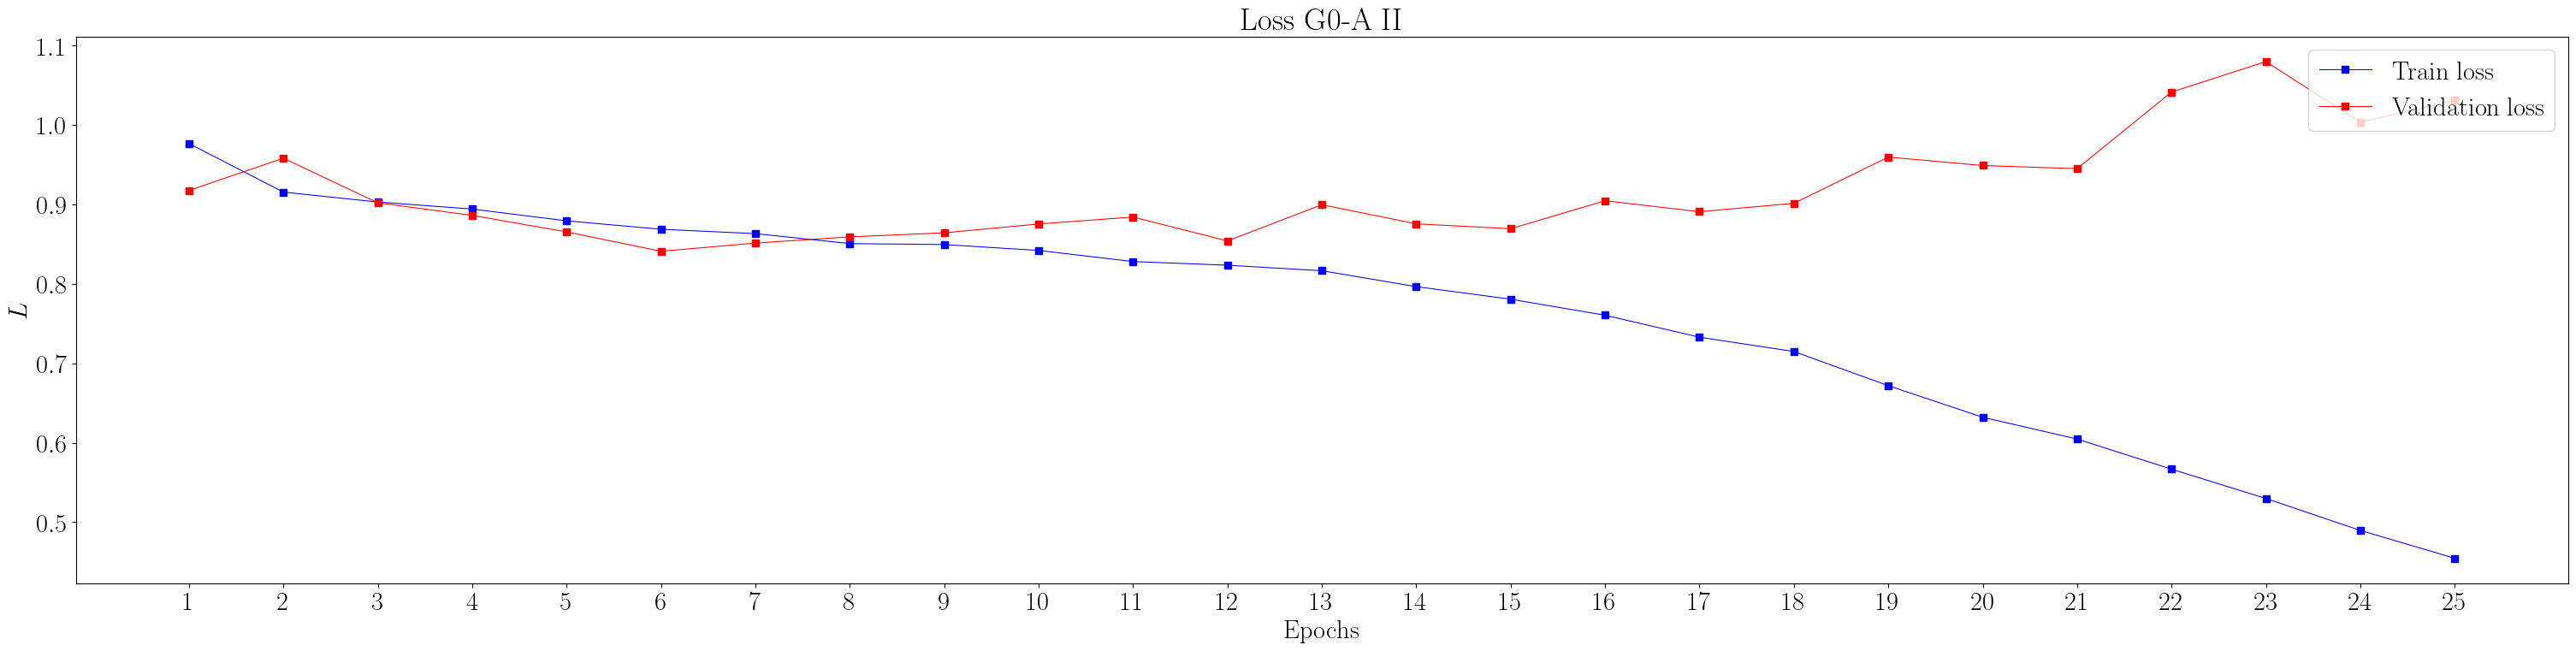

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

n_epochs = 25

fig1, ax = plt.subplots(nrows=1, ncols=1,figsize=(30, 7.5), #width, height
                            sharex=True,constrained_layout=True)

load = "G0-A II"

ax.set_ylabel(r"$L$")
ax.set_title(r"Loss G0-A II")
ax.set_xlabel("Epochs")

formatter = mticker.ScalarFormatter()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(1, n_epochs + 1, 1)))


ax.plot(range(1, len(train_loss) + 1), train_loss, marker='s', color="b", linewidth=0.75, label="Train loss")
ax.plot(range(1, len(val_loss) + 1), val_loss, marker="s", color="r", linewidth=0.75, label="Validation loss")
ax.legend(loc='upper right')
"""
#axins = zoomed_inset_axes(ax, 5, loc="center right")
axins = ax.inset_axes([0.5, 0.25, 0.5, 0.5])
axins.set_xlim(3.5, 20.5)
axins.set_ylim(1, 1)
axins.plot(range(1, len(train_loss) + 1), train_loss, marker='s', color="b", linewidth=0.75, label="Train loss")
axins.plot(range(1, len(val_loss) + 1), val_loss, marker="s", color="r", linewidth=0.75, label="Validation loss")
axins.xaxis.set_major_locator(mticker.FixedLocator(np.arange(1, n_epochs + 1, 1)))
plt.xticks(visible=True)
plt.yticks(visible=True)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
"""
plt.savefig(load + "_epoch_loss.pdf", dpi=200)


plt.show()

In [ ]:
test_signal = np.load("test_signal.npy", allow_pickle=True)
test_signal = test_signal.item()
test_signal

{'target': array([[-0.9470111 -0.6424606j ],
        [-0.5690671 -0.33196315j],
        [-1.0157292 -0.5537485j ],
        ...,
        [-0.17324758-0.44196737j],
        [-0.61990964-0.66375273j],
        [-1.1875191 -0.7081087j ]], dtype=complex64),
 'pred': array([[-0.41440076-0.6015508j ],
        [-0.8961265 -0.64735353j],
        [-0.6076842 -0.51885j   ],
        ...,
        [-0.6059498 -0.7544387j ],
        [-0.45551264-0.78603727j],
        [-0.6696363 -0.79278857j]], dtype=complex64)}

In [ ]:
p_signal = {"target": np.real(test_signal["target"])*statistics[2] + statistics[0],
            "pred": np.real(test_signal["pred"])*statistics[2] + statistics[0]}

q_signal = {"target": np.imag(test_signal["target"])*statistics[3] + statistics[1],
            "pred": np.imag(test_signal["pred"])*statistics[3] + statistics[1]}



<ipython-input-123-5758da48237f>:1: DeprecationWarning: Please use `argsort` from the `scipy.linalg` namespace, the `scipy.linalg.decomp` namespace is deprecated.
  from scipy.linalg.decomp import argsort


{'MAD': 13.286475, 'MAPE': 0.11486804, 'MAD%': 0.13142532, 'BIAS': 5.41825, 'MSE': 399.78995, 'RMSE': 19.994747}
{'MAD': 9.684476, 'MAPE': 0.24013247, 'MAD%': 0.2646878, 'BIAS': 3.3949282, 'MSE': 228.15646, 'RMSE': 15.104849}


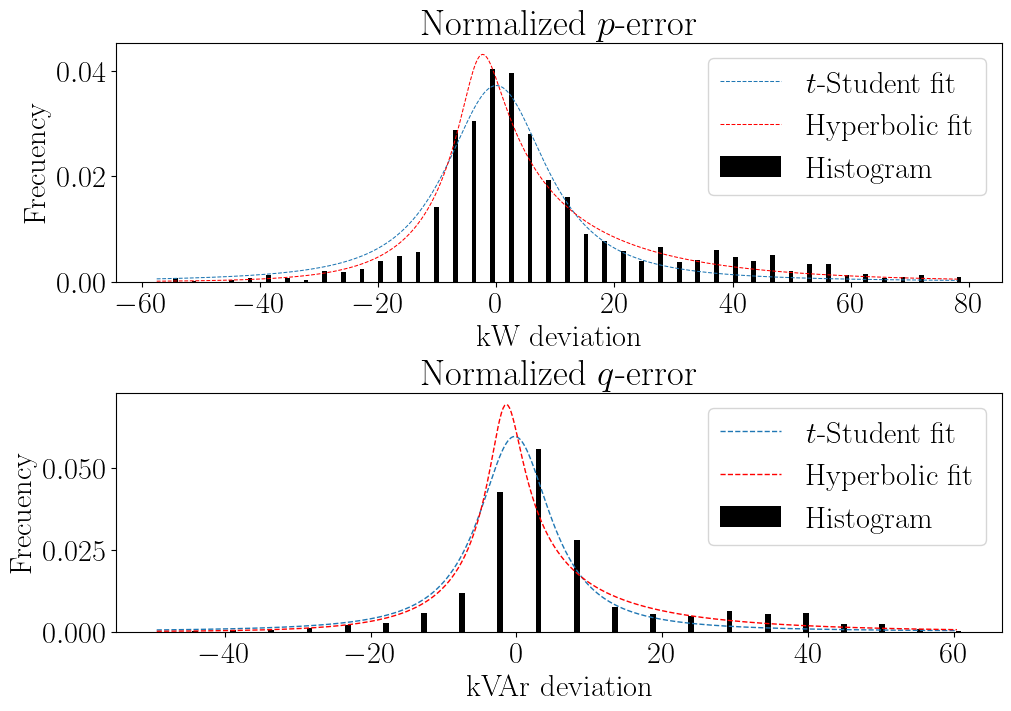

In [ ]:
from scipy.linalg.decomp import argsort
def metric(signal):
  metrics = dict()
  errors = signal["target"] - signal["pred"]
  metrics["MAD"] = np.mean(np.abs(errors))
  metrics["MAPE"] = np.mean([error/signal["target"][idx] for idx, error in enumerate(np.abs(errors)) if signal["target"][idx] > 0.1])
  metrics["MAD%"] = metrics["MAD"]/np.mean(np.abs(signal["target"]))
  metrics["BIAS"] = np.mean(errors)
  metrics["MSE"] = np.mean(errors**2)
  metrics["RMSE"] = np.sqrt(np.mean(errors**2))
  print(metrics)
  for idx, error in enumerate(np.abs(errors)):
    if signal["target"][idx] == 0.0:
      print(idx)
  return errors, metrics


from scipy.stats import norm, genhyperbolic, t
from scipy.stats import exponnorm as weibull
p_error, p_metrics  = metric(p_signal)
q_error, q_metrics = metric(q_signal)
errors = (p_error, q_error)


fig1, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 7), #width, height
                          sharex=False,constrained_layout=True)
hist, bin_edges  = np.histogram(p_error, bins=43, range=None, normed=None, weights=None, density=True)
label1 = r"Histogram"
axs[0].bar(bin_edges[1:], hist, label=label1, color="black")
nu = t.fit(p_error)#####

hist, bin_edges  = np.histogram(errors[0], bins=500, range=None, normed=None, weights=None, density=True)
y = t.pdf(bin_edges[:-1], *nu) #####
l = axs[0].plot(bin_edges[:-1], y, '--', linewidth=0.75, label=r"$t$-Student fit")

args = genhyperbolic.fit(p_error)

y = genhyperbolic.pdf(bin_edges[:-1], *args)
l = axs[0].plot(bin_edges[:-1], y, 'r--', linewidth=0.75, label=r"Hyperbolic fit")
axs[0].legend()



hist, bin_edges  = np.histogram(errors[1], bins=21, range=None, normed=None, weights=None, density=True)
label2 = r"Histogram"
axs[1].bar(bin_edges[1:], hist, label=label2, color="black")
nu = t.fit(q_error)
hist, bin_edges  = np.histogram(errors[1], bins=500, range=None, normed=None, weights=None, density=True)
y = t.pdf(bin_edges[:-1], *nu)
l = axs[1].plot(bin_edges[:-1], y, '--', linewidth=1, label=r"$t$-Student fit")
args = genhyperbolic.fit(q_error)
y = genhyperbolic.pdf(bin_edges[:-1], *args)
l = axs[1].plot(bin_edges[:-1], y, 'r--', linewidth=1, label=r"Hyperbolic fit")
axs[1].legend()
axs[0].set_title(r"Normalized $p$-error")
axs[0].set_xlabel(r"kW deviation")
axs[0].set_ylabel(r"Frecuency")
axs[1].set_xlabel(r"kVAr deviation")
axs[1].set_ylabel(r"Frecuency")
axs[1].set_title(r"Normalized $q$-error")

plt.savefig("errors.pdf", dpi=200)

plt.show()


Test Loss: 19.208433151245117

In [ ]:
15.16438 + 4.0440545

19.2084345

In [ ]:
# Small bins
p_error = p_error.reshape(1495, )
q_error = q_error.reshape(1495, )
plt.hist2d(p_error, q_error, bins=(100,100), cmap=plt.cm.jet, density=True, range=[[-20, 15], [-20,15]])
plt.colorbar()

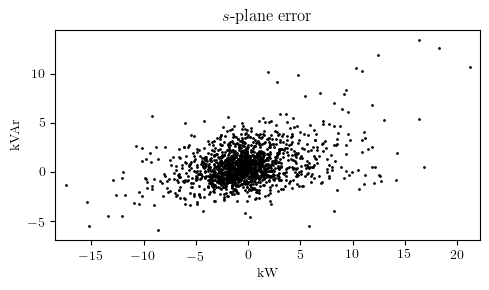

array([[1.        , 0.37892792],
       [0.37892792, 1.        ]])

In [ ]:
from scipy.stats import kde

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(5, 3))
corr = np.corrcoef(p_error, q_error)
axes.set_title(r'$s$-plane error')
axes.set_ylim(q_error.min()-1, q_error.max()+1)
axes.set_xlim(p_error.min()-1, p_error.max()+1)
axes.set_xlabel("kW")

axes.set_ylabel("kVAr")

kdefig = axes.scatter(p_error, q_error, marker='o', s=1, color='k')
fig.tight_layout()
plt.savefig("cplane.pdf", dpi=200)
#axes.contour(xi, yi, zi.reshape(xi.shape) )
plt.show()
corr

[[1.         0.37892792]
 [0.37892792 1.        ]]
[[1.         0.37892792]
 [0.37892792 1.        ]]
[[1.         0.37892792]
 [0.37892792 1.        ]]


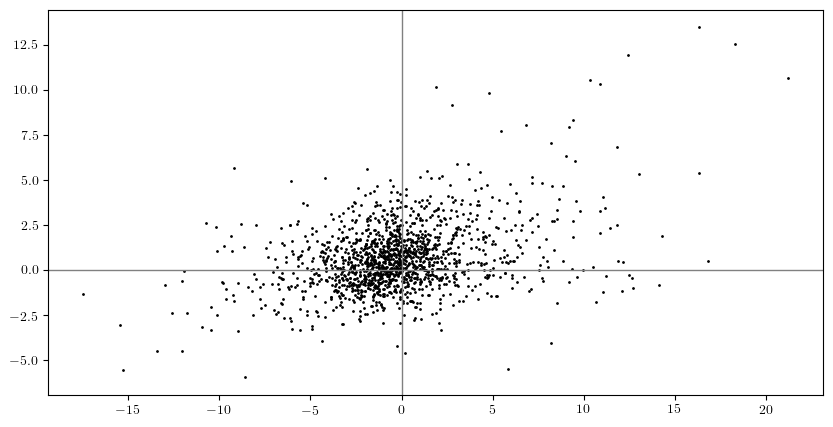

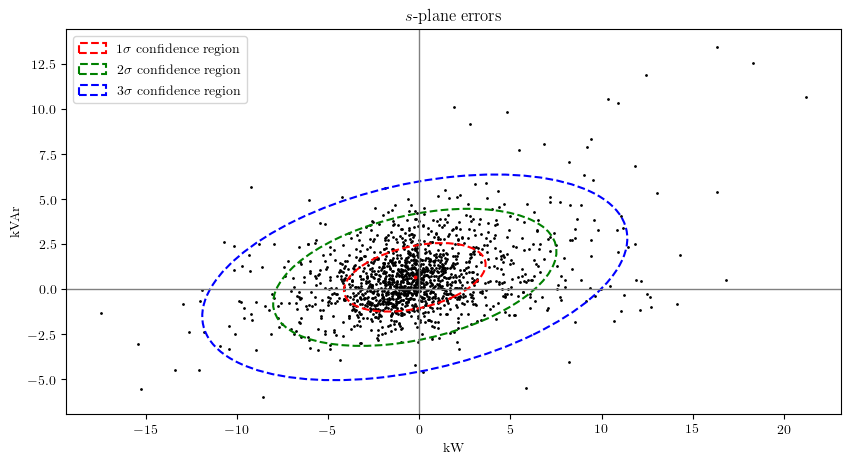

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    print(np.corrcoef(x, y))
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, ax_nstd = plt.subplots(figsize=(10, 5))


ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = p_error.reshape(1495,), q_error.reshape(1495,)

mu = x.mean(), y.mean()
ax_nstd.scatter(x, y,  marker='o', s=1, color='k')

confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$ confidence region', edgecolor='red', linestyle='--', linewidth=1.5)
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$ confidence region', edgecolor='green', linestyle='--', linewidth=1.5)
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$ confidence region', edgecolor='blue', linestyle='--', linewidth=1.5)

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title(r'$s$-plane errors')
ax_nstd.set_xlabel("kW")

ax_nstd.set_ylabel("kVAr")
ax_nstd.legend()
plt.savefig("cplane.pdf", dpi=200)
plt.show()